In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statutils

plt.rcParams['figure.figsize'] = (20, 10)

<br>

How well does a linear regression fit unrelated data when $ N_{samples} - N_{variables} << N_{variables} $

In [3]:
N = 1000
n = 950

X = np.random.normal(size=(N, n))
y = np.random.normal(size=(N,))

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                              1.819
Date:                Sun, 19 Dec 2021   Prob (F-statistic):                     0.00457
Time:                        12:10:34   Log-Likelihood:                          346.34
No. Observations:                1000   AIC:                                      1207.
Df Residuals:                      50   BIC:                                      5870.
Df Model:                         950                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [4]:
mse, ystd = np.linalg.norm(result.resid)**2/N, y.std()**2
r_sqrd = 1 - (mse/ystd)
r_sqrd

0.9718732022217393

<br>

#### What is the relationship between $ N_{variables}/N_{samples} $ and $MSE$ when there is no relationship between $X$ and $y$? 

Define different distributions for the unrelated $X, y$

In [21]:
# X ~ normal, y ~ normal
def get_samples(N, n):
    X = np.random.normal(size=(N, n))
    y = np.random.normal(size=(N,))
    return X,y 

In [6]:
# X ~ binomial, y ~ binomial
def get_samples(N, n):
    X = np.random.binomial(30, 0.9654746681256314, size=(N, n))
    y = np.random.binomial(30, 0.9654746681256314, size=(N,))
    return X,y 

In [22]:
# X ~ poisson, y ~ poisson
def get_samples(N, n):
    X = np.random.poisson(1, size=(N, n))
    y = np.random.poisson(1, size=(N,))
    return X,y 

In [23]:
# X ~ poisson, y ~ binomial
def get_samples(N, n):
    X = np.random.poisson(1, size=(N, n))
    y = np.random.binomial(30, 0.9654746681256314, size=(N,))
    return X,y 

<br>

Run experiments

In [17]:
# run many linear models of overdetermined linear systems
# use N_samples ~ uniform(min_samp, max_samp)
# use N_variables ~ uniform(1, N_samples)
# generate unrelated X, y where X is (N_samples x N_variables)
# compute (N_variables/N_samples, MSE)

# how many experiments to run
N_iter = 1000

# sample size
max_samp = 300
min_samp = 2

# results ~ [ (N_variables/N_samples, MSE), ... ]
results = list()

for i in range(N_iter):

    if (i%10 == 0):
        print(f'\r{round(100*i/N_iter, 2)}%', end='')
    
    N = np.random.randint(min_samp, max_samp)
    n = np.random.randint(1, N)

    X,y = get_samples(N, n)

    model = sm.OLS(y, X)
    result = model.fit()

    mse = np.linalg.norm(result.resid)**2/N
    r_sqd = mse/(y.std()**2)

    results.append({
        "N" : N,
        "n" : n,
        "n/N" : n/float(N),
        "MSE" : mse,
        "R^2" : r_sqd
    })

df = pd.DataFrame(results)
df.head()

99.0%

,N,n,n/N,MSE,R^2
0,272,72,0.264706,0.724640,0.786777
1,215,208,0.967442,0.022659,0.023681
2,135,26,0.192593,0.800431,0.813353
3,15,13,0.866667,0.170115,0.337738
4,271,137,0.505535,0.548528,0.499151


In [25]:
# smooth results
xh, yh, errs = statutils.gaussian_filter(df['n/N'].values, df['MSE'].values, nx=1000, sigma=0.02, nsigma=20)

Text(0, 0.5, 'MSE')

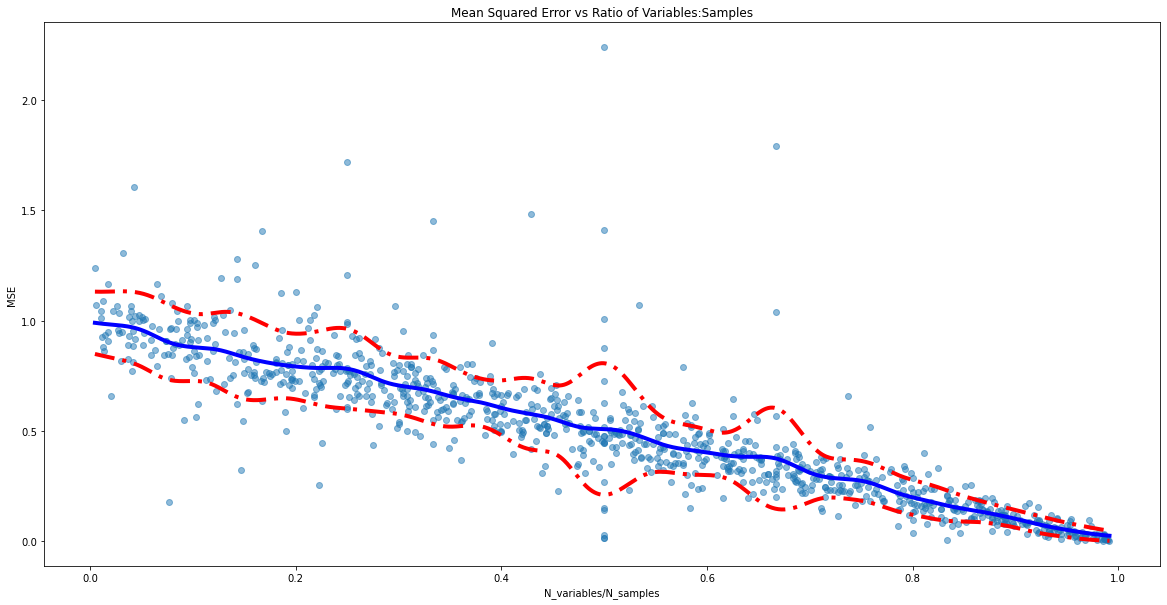

In [26]:
dashed_style = (0, (5, 2, 1, 2))
lwidth = 4

plt.plot(xh, yh, color='b', linewidth=lwidth)
plt.plot(xh, yh+errs, color='r', linewidth=lwidth, linestyle=dashed_style)
plt.plot(xh, yh-errs, color='r', linewidth=lwidth, linestyle=dashed_style)
plt.scatter(df['n/N'], df['MSE'], alpha=0.5)
plt.title('Mean Squared Error vs Ratio of Variables:Samples')
plt.xlabel('N_variables/N_samples')
plt.ylabel('MSE')